# ECE570: A Reimplementation of DIFUSCO for the Final Project

## How to Run the Code

To run this project successfully, please follow these steps:

1. **Install Conda (if not already installed)**

   If you do not have Conda installed, download and install **Miniconda** from the official website:

   - [Miniconda Download Page](https://docs.conda.io/en/latest/miniconda.html)

   Choose the appropriate installer for your operating system (Windows, macOS, or Linux) and follow the installation instructions.

   Once installed, you can verify the installation by running:

   ```bash
   conda --version

2. **Create the Environment:**

   Use the provided `requirements.yml` file to create a Conda environment:

   ```bash
   conda env create -f requirements.yml

3. **Activate the environment**

    Activate the environment by typing out the following command in your terminal

    ```bash
   conda activate <environment_name>

4. **Note:**

   *All* the code that you will find in this .ipynb file is my own. However, I need certain utility functions to run this code. All the utility functions are found in the utils directory. The functions I use from utils are not my own!


## Dataset Generation for TSP Instances

This section defines a custom dataset generator for the Traveling Salesman Problem (TSP). The generator creates synthetic instances of the TSP by randomly generating coordinates for a given number of cities, and then solving the optimal tour using either the **Concorde** or **LKH** TSP solvers.

### TSPSampleGenerator Class

The `TSPSampleGenerator` class automates the creation of datasets for TSP by:
- Randomly selecting a number of cities between a minimum and maximum range.
- Generating random 2D coordinates for the cities.
- Solving the TSP instance using either the Concorde or LKH solver.
- Writing the instance and its optimal tour to a text file in the following format:



In [ ]:
import os
import time
import warnings
import contextlib
import io

import numpy as np
import tqdm
import tsplib95
import lkh
from concorde.tsp import TSPSolver  # https://github.com/jvkersch/pyconcorde
from multiprocessing import Pool
warnings.filterwarnings("ignore")

class TSPSampleGenerator:
    def __init__(self, min_city_count=20, max_city_count=50, sample_count=128000, group_size=128, 
                 tsp_method="lkh", trial_count=1000, random_seed=1234, output_dir="Dataset_Generated", dataset_type="train"):
        self.min_city_count = min_city_count
        self.max_city_count = max_city_count
        self.sample_count = sample_count
        self.group_size = group_size
        self.tsp_method = tsp_method
        self.trial_count = trial_count
        self.random_seed = random_seed
        self.output_dir = output_dir
        self.dataset_type = dataset_type
        
        np.random.seed(self.random_seed)
        os.makedirs(self.output_dir, exist_ok=True)
        self.out_file = f"{self.output_dir}/tsp{self.min_city_count}-{self.max_city_count}_{self.dataset_type}.txt"
    
    @staticmethod
    def compute_optimal_tour(city_coords, city_count, tsp_method, trial_count):
        scale = 1e6
        if tsp_method == "concorde":
            solver_instance = TSPSolver.from_data(city_coords[:, 0] * scale, 
                                                   city_coords[:, 1] * scale, 
                                                   norm="EUC_2D")
            # Suppress solver output
            with contextlib.redirect_stdout(io.StringIO()):
                solution = solver_instance.solve(verbose=False)
            tour = solution.tour
        elif tsp_method == "lkh":
            lkh_executable = 'LKH-3.0.6/LKH'
            problem = tsplib95.models.StandardProblem()
            problem.name = 'TSP'
            problem.type = 'TSP'
            problem.dimension = city_count
            problem.edge_weight_type = 'EUC_2D'
            problem.node_coords = {i + 1: city_coords[i] * scale for i in range(city_count)}
            solution = lkh.solve(lkh_executable, problem=problem, max_trials=trial_count, runs=10)
            tour = [i - 1 for i in solution[0]]
        else:
            raise ValueError(f"Unknown TSP method: {tsp_method}")
        return tour

    def create_dataset(self):
        start = time.time()
        with open(self.out_file, "w") as out_f:
            for batch_idx in tqdm.tqdm(range(self.sample_count // self.group_size), disable=True):
                # Randomly determine the number of cities for this batch.
                current_city_count = np.random.randint(low=self.min_city_count, high=self.max_city_count + 1)
                # Generate random coordinates for each sample in this group.
                batch_coords = np.random.random((self.group_size, current_city_count, 2))
                
                # Compute the TSP tour for each sample concurrently.
                with Pool(self.group_size) as pool:
                    tours = pool.starmap(self.compute_optimal_tour, 
                        [(batch_coords[i], current_city_count, self.tsp_method, self.trial_count) 
                         for i in range(self.group_size)]
                    )

                for i, tour in enumerate(tours):
                    if (np.sort(tour) == np.arange(current_city_count)).all():
                        coord_str = " ".join(f"{x:.6f} {y:.6f}" for x, y in batch_coords[i])
                        tour_str = " ".join(str(node + 1) for node in tour)
                        out_f.write(f"{coord_str} output {tour_str} {tour[0] + 1}\n")
        elapsed = time.time() - start
        print(f" Generated {self.sample_count} samples of TSP{self.min_city_count}-{self.max_city_count} ({self.dataset_type}).")
        print(f" Total time: {elapsed/60:.1f} min, Avg time per sample: {elapsed/self.sample_count:.2f} s")


Tours are 1-indexed, and each line corresponds to one problem instance.

### Notes on Performance

⚠️ **This cell takes approximately 20 minutes to run**, especially with large sample sizes. The use of multiprocessing improves runtime, but it is still computation-intensive due to solving each TSP instance optimally.

### Example Usage

Three datasets are generated using this code:
- **Training set** with 12800 samples
- **Validation set** with 640 samples
- **Test set** with 640 samples

Each is generated by initializing the `TSPSampleGenerator` with the appropriate parameters and calling `create_dataset()`.

### Solvers

- **Concorde**: Known for optimal TSP solving, used via the `pyconcorde` wrapper.
- **LKH**: Another high-performance heuristic solver, useful for larger graphs or quicker generation.

These datasets will be used later to train and evaluate the DIFUSCO model. Finally, you should have 3 files saved inside ./data with all the tsp instances.


In [ ]:
#Note !!! This cell takes approximately 20 mins to run, so be patient.
min_nodes    = 20
max_nodes    = 50
num_samples  = 12800    # (use 128000 for training; here 12800 for testing/validation)
group_size   = 64      # batch_size set to 64
solver       = "concorde"  # or "lkh"
lkh_trials   = 1000
seed         = 1234
save_dir     = "Dataset_Generated"
dataset_type = "train"   # can be "val" or "test" or train

# Instantiate the generator with old parameters
generator = TSPSampleGenerator(
    min_city_count=min_nodes,
    max_city_count=max_nodes,
    sample_count=num_samples,
    group_size=group_size,
    tsp_method=solver,
    trial_count=lkh_trials,
    random_seed=seed,
    output_dir=save_dir,
    dataset_type=dataset_type
)

# Run the dataset generation
generator.create_dataset()

num_samples = 640
dataset_type = "val"
generator = TSPSampleGenerator(
    min_city_count=min_nodes,
    max_city_count=max_nodes,
    sample_count=num_samples,
    group_size=group_size,
    tsp_method=solver,
    trial_count=lkh_trials,
    random_seed=seed,
    output_dir=save_dir,
    dataset_type=dataset_type
)
# Run the dataset generation
generator.create_dataset()

num_samples = 640
dataset_type = "test"
generator = TSPSampleGenerator(
    min_city_count=min_nodes,
    max_city_count=max_nodes,
    sample_count=num_samples,
    group_size=group_size,
    tsp_method=solver,
    trial_count=lkh_trials,
    random_seed=seed,
    output_dir=save_dir,
    dataset_type=dataset_type
)
# Run the dataset generation
generator.create_dataset()

Problem Name: 7cc932d3aeac4302b6381276de4770c7
Problem Type: TSP
Number of Nodes: 20
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 3493267
   0 Steps   Best: 3382368   0.00 seconds
   1 Steps   Best: 3323724   0.00 seconds
  10 Total Steps.
Best cycle length: 3323724
Lin-Kernighan Running Time: 0.00
LK Initial Run: 3323724.0
LK Run 0: 3323724.0
LK Run from best tour: 3323724.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 3323724 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 3206815.500000  (0.00 seconds)
  LP Value  2: 3323724.000000  (0.00 seconds)
New lower bound: 3323724.000000
Exact lower bound: 3323724.000000
DIFF: 0.000000
Established Bound: 3323724
Optimal tour: 3323724
Total Time to solve TSP: 0.00


ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


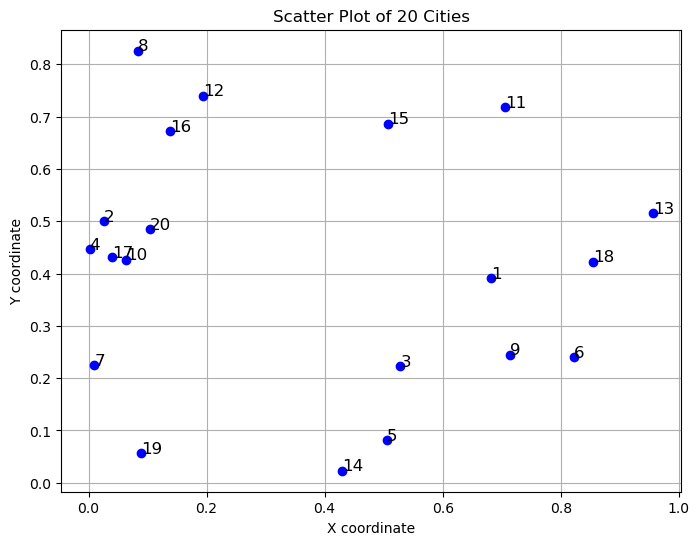

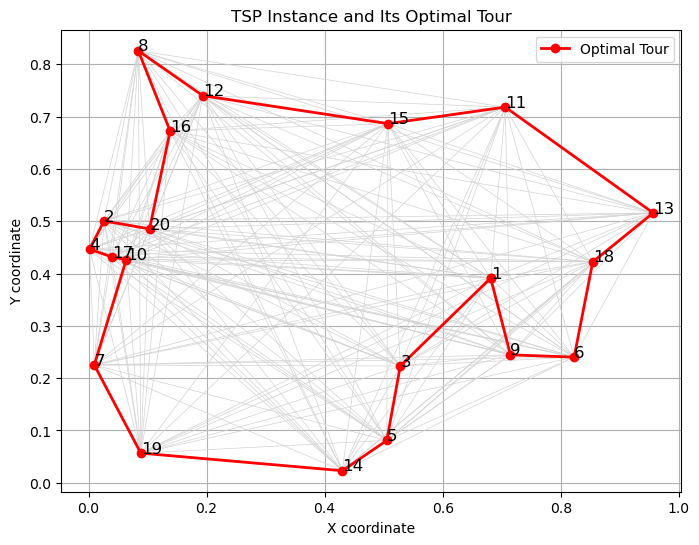

In [62]:
import numpy as np
import matplotlib.pyplot as plt

num_nodes = 20

nodes_coord = np.random.random((num_nodes, 2))
solver = "concorde"
trial_count = 1000
# Use the TSPSampleGenerator's static method to compute the optimal tour.
# (Note: In the new class, the method is named 'compute_optimal_tour')
tour = TSPSampleGenerator.compute_optimal_tour(nodes_coord, num_nodes, solver, trial_count)

# ----------------- Plot 1: Scatter plot of cities -----------------
plt.figure(figsize=(8, 6))
plt.scatter(nodes_coord[:, 0], nodes_coord[:, 1], color='blue', zorder=5)
# Annotate each city with its index (starting from 1)
for i, (x, y) in enumerate(nodes_coord):
    plt.text(x, y, str(i + 1), fontsize=12, color='black', zorder=10)
plt.title("Scatter Plot of 20 Cities")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.show()

# ----------------- Plot 2: Complete graph with all edges and optimal tour -----------------
plt.figure(figsize=(8, 6))

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        plt.plot([nodes_coord[i, 0], nodes_coord[j, 0]],
                 [nodes_coord[i, 1], nodes_coord[j, 1]],
                 color='lightgray', linewidth=0.5)
tour_coords = np.array([nodes_coord[i] for i in tour] + [nodes_coord[tour[0]]])
plt.plot(tour_coords[:, 0], tour_coords[:, 1],
         color='red', linewidth=2, marker='o', markersize=6, label='Optimal Tour')

# Annotate each city in the tour plot
for i, (x, y) in enumerate(nodes_coord):
    plt.text(x, y, str(i + 1), fontsize=12, color='black', zorder=10)

plt.title("TSP Instance and Its Optimal Tour")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.grid(True)
plt.show()


## TSPDataset: PyTorch Dataset for TSP Instances

The `TSPDataset` class is a custom `torch.utils.data.Dataset` implementation designed to load and preprocess Traveling Salesman Problem (TSP) instances from a text file.

Each line of the input file contains a single TSP instance in the following format:

This is a TSPDataset which reads the files generated by the previous section and uses them in to create a Dataloader/Dataset

In [ ]:
import os
import numpy as np
import torch
from sklearn.neighbors import KDTree
from torch_geometric.data import Data as GraphObj

class TSPDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, neighbor_count=-1):
        self.file_path = file_path
        self.neighbor_count = neighbor_count
        self.lines = open(file_path).read().splitlines()
        print(f'Loaded "{file_path}" with {len(self.lines)} lines')

    def __len__(self):
        return len(self.lines)

    def fetch_sample(self, index):
        # Select sample
        line_text = self.lines[index]
        # Clear leading/trailing whitespace
        line_text = line_text.strip()

        # Extract coordinates
        coord_part = line_text.split(' output ')[0]
        coord_part = coord_part.split(' ')
        coordinates = np.array([[float(coord_part[i]), float(coord_part[i + 1])] 
                                for i in range(0, len(coord_part), 2)])
        # Extract route
        route_part = line_text.split(' output ')[1]
        route_part = route_part.split(' ')
        route = np.array([int(r) for r in route_part])
        route -= 1

        return coordinates, route

    def __getitem__(self, index):
        coordinates, route = self.fetch_sample(index)
        if self.neighbor_count <= 0:
            # Return a densely connected graph
            adjacency_matrix = np.zeros((coordinates.shape[0], coordinates.shape[0]))
            for i in range(route.shape[0] - 1):
                adjacency_matrix[route[i], route[i + 1]] = 1
            return (
                torch.LongTensor(np.array([index], dtype=np.int64)),
                torch.from_numpy(coordinates).float(),
                torch.from_numpy(adjacency_matrix).float(),
                torch.from_numpy(route).long(),
            )
        else:
            k_val = self.neighbor_count
            tree = KDTree(coordinates, leaf_size=30, metric='euclidean')
            dists, neighbor_idxs = tree.query(coordinates, k=k_val, return_distance=True)

            edge_src = torch.arange(coordinates.shape[0]).reshape((-1, 1)).repeat(1, k_val).reshape(-1)
            edge_dst = torch.from_numpy(neighbor_idxs.reshape(-1))

            edges = torch.stack([edge_src, edge_dst], dim=0)

            route_edges = np.zeros(coordinates.shape[0], dtype=np.int64)
            route_edges[route[:-1]] = route[1:]
            route_edges = torch.from_numpy(route_edges)
            route_edges = route_edges.reshape((-1, 1)).repeat(1, k_val).reshape(-1)
            route_edges = torch.eq(edge_dst, route_edges).reshape(-1, 1)
            graph_obj = GraphObj(
                x=torch.from_numpy(coordinates).float(),
                edge_index=edges,
                edge_attr=route_edges
            )

            num_points = np.array([coordinates.shape[0]], dtype=np.int64)
            num_edges = np.array([edges.shape[1]], dtype=np.int64)
            return (
                torch.LongTensor(np.array([index], dtype=np.int64)),
                graph_obj,
                torch.from_numpy(num_points).long(),
                torch.from_numpy(num_edges).long(),
                torch.from_numpy(route).long(),
            )
#Executed until here with no errors (saved)

**Imports from utils** 

In [42]:
from utils.diffusion_schedulers import GaussianDiffusion, CategoricalDiffusion, InferenceSchedule
from utils.lr_schedulers import get_schedule_fn
from utils.tsp_utils import *

## GNNEncoder: Extended Sparse & Dense Graph Encoder

This module defines an enhanced `GNNEncoder` for processing graph-structured data in both dense and sparse formats, specifically tailored for diffusion-based combinatorial optimization tasks like TSP.

### GraphCore

The `GraphCore` class (formerly `ProcessGraph`) defines a single graph message-passing layer:
- Performs learnable transformations on node and edge features.
- Applies gating mechanisms using edge representations.
- Aggregates neighborhood information using `sum`, `mean`, or `max`.
- Applies normalization (`BatchNorm` or `LayerNorm`) and residual connections.

### Positional Embedding Modules

- `PosEncSin`: 2D positional sine encoding for node coordinates.
- `SclrEncSin`: Scalar sine encoding for edge features.
- `SclrEncSin1D`: 1D variant for use in node-only setups.

### GNNEncoder Class

The `GNNEncoder` stacks multiple `GraphCore` layers and adds the following capabilities:

#### Key Features
- **Flexible Aggregation:** Sum, mean, or max-based neighborhood aggregation.
- **Positional Encoding:** Integrates spatial awareness into node/edge features.
- **Time Embeddings:** Uses sinusoidal timestep embeddings for the diffusion model.

#### Main Components
- `layer_outputs`: Outputs a processed signal for edge features at each layer.
- `final_out`: Final convolutional head for producing prediction logits.

### Forward Modes

- `dense_processing`: Handles dense graphs with full adjacency matrices.
- `sparse_processing`: Processes sparse graphs using edge index and features.
- `sparse_processing_node_only`: Special mode for node-only sparse graph setups.
- `forward`: Automatically dispatches to the correct method based on flags.

### Summary

This encoder is a powerful building block in DIFUSCO’s architecture, designed for scalability and flexibility across various types of graph inputs. It merges positional awareness, gated message passing, and diffusion-aware time conditioning in a single unified module.


In [ ]:
import functools
import math
import torch
import torch.nn.functional as F
from torch import nn
import torch.utils.checkpoint as act_checkpoint

from utils.nn import linear as helper_linear, zero_module as helper_zero, normalization as helper_norm, timestep_embedding as helper_time_embed

from torch_sparse import SparseTensor
from torch_sparse import sum as sparse_total
from torch_sparse import mean as sparse_average
from torch_sparse import max as sparse_opt


class GraphCore(nn.Module):
    def __init__(self, hidden_dim, aggregate_type="sum", norm_type="batch", enable_affine=True, monitor_stats=False, gated_switch=True):
        super(GraphCore, self).__init__()
        self.hidden_dim = hidden_dim
        self.aggregate_type = aggregate_type
        self.norm_type = norm_type
        self.enable_affine = enable_affine
        self.monitor_stats = monitor_stats
        self.gated_switch = gated_switch
        assert self.gated_switch, "Only gated_switch version is implemented. Please do not change this argument"

        self.lin_U = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.lin_V = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.lin_A = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.lin_B = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.lin_C = nn.Linear(hidden_dim, hidden_dim, bias=True)

        norm_dict = {
            "layer": nn.LayerNorm(hidden_dim, elementwise_affine=enable_affine),
            "batch": nn.BatchNorm1d(hidden_dim, affine=enable_affine, track_running_stats=monitor_stats)
        }
        self.core_norm_node = norm_dict.get(norm_type, None)
        self.core_norm_edge = norm_dict.get(norm_type, None)

    def forward(self, node_feats, edge_feats, conn_matrix, merge_mode="residual", edge_idx=None, sparse_flag=False):
        # Determine shapes
        if sparse_flag:
            b_size = None
            num_nodes, dim_hidden = node_feats.shape
        else:
            b_size, num_nodes, dim_hidden = node_feats.shape

        # Save original inputs for residual connection
        orig_nodes = node_feats
        orig_edges = edge_feats

        # Compute linear transformations
        U_result = self.lin_U(node_feats)
        V_temp = self.lin_V(node_feats)
        if not sparse_flag:
            V_result = V_temp.unsqueeze(1).expand(-1, num_nodes, -1, -1)
        else:
            V_result = self.lin_V(node_feats[edge_idx[1]])  # shape: E x H

        A_result = self.lin_A(node_feats)
        B_result = self.lin_B(node_feats)
        C_result = self.lin_C(edge_feats)

        # Combine features to produce edge representations
        if not sparse_flag:
            combined_edges = A_result.unsqueeze(1) + B_result.unsqueeze(2) + C_result
        else:
            combined_edges = A_result[edge_idx[1]] + B_result[edge_idx[0]] + C_result
        gate_vals = torch.sigmoid(combined_edges)

        aggregated = self.aggregate(V_result, conn_matrix, gate_vals, edge_index=edge_idx, sparse_flag=sparse_flag)
        updated_nodes = U_result + aggregated

        # Apply normalization if set
        if not sparse_flag:
            if self.core_norm_node is not None:
                updated_nodes = self.core_norm_node(updated_nodes.view(b_size * num_nodes, dim_hidden)).view(b_size, num_nodes, dim_hidden)
            if self.core_norm_edge is not None:
                combined_edges = self.core_norm_edge(combined_edges.view(b_size * num_nodes * num_nodes, dim_hidden)).view(b_size, num_nodes, num_nodes, dim_hidden)
        else:
            if self.core_norm_node is not None:
                updated_nodes = self.core_norm_node(updated_nodes)
            if self.core_norm_edge is not None:
                combined_edges = self.core_norm_edge(combined_edges)

        updated_nodes = F.relu(updated_nodes)
        combined_edges = F.relu(combined_edges)

        if merge_mode == "residual":
            updated_nodes = orig_nodes + updated_nodes
            combined_edges = orig_edges + combined_edges

        return updated_nodes, combined_edges

    def aggregate(self, V_tensor, conn_matrix, gate_tensor, edge_index=None, sparse_flag=False, agg_method=None):
        gated_vals = gate_tensor * V_tensor
        method = agg_method or self.aggregate_type
        if not sparse_flag:
            if method == "mean":
                divisor = torch.sum(conn_matrix, dim=2).unsqueeze(-1).type_as(gated_vals)
                return torch.sum(gated_vals, dim=2) / divisor
            elif method == "max":
                return torch.max(gated_vals, dim=2)[0]
            else:
                return torch.sum(gated_vals, dim=2)
        else:
            sparse_obj = SparseTensor(
                row=edge_index[0],
                col=edge_index[1],
                value=gated_vals,
                sparse_sizes=(conn_matrix.size(0), conn_matrix.size(1))
            )
            if method == "mean":
                return sparse_average(sparse_obj, dim=1)
            elif method == "max":
                return sparse_opt(sparse_obj, dim=1)
            else:
                return sparse_total(sparse_obj, dim=1)


# Renamed from PositionEmbeddingSine
class PosEncSin(nn.Module):
    def __init__(self, num_features=64, temp_value=10000, do_normalize=False, factor_scale=None):
        super().__init__()
        self.num_features = num_features
        self.temp_value = temp_value
        self.do_normalize = do_normalize
        if factor_scale is not None and not do_normalize:
            raise ValueError("do_normalize must be True if factor_scale is provided")
        self.factor_scale = factor_scale if factor_scale is not None else 2 * math.pi

    def forward(self, inp_tensor):
        coord_y = inp_tensor[:, :, 0]
        coord_x = inp_tensor[:, :, 1]
        if self.do_normalize:
            coord_y = coord_y * self.factor_scale
            coord_x = coord_x * self.factor_scale
        device = inp_tensor.device
        idx_range = torch.arange(self.num_features, dtype=torch.float32, device=device)
        exponent_val = 2.0 * torch.div(idx_range, 2, rounding_mode='trunc') / self.num_features
        scaling = self.temp_value ** exponent_val

        pos_x_enc = coord_x.unsqueeze(2) / scaling
        pos_y_enc = coord_y.unsqueeze(2) / scaling

        sin_x = torch.sin(pos_x_enc[:, :, 0::2])
        cos_x = torch.cos(pos_x_enc[:, :, 1::2])
        sin_y = torch.sin(pos_y_enc[:, :, 0::2])
        cos_y = torch.cos(pos_y_enc[:, :, 1::2])
        enc_x = torch.stack((sin_x, cos_x), dim=3).flatten(2)
        enc_y = torch.stack((sin_y, cos_y), dim=3).flatten(2)
        combined_enc = torch.cat((enc_y, enc_x), dim=2).contiguous()
        return combined_enc


class SclrEncSin(nn.Module):
    def __init__(self, num_features=64, temp_value=10000, do_normalize=False, factor_scale=None):
        super().__init__()
        self.num_features = num_features
        self.temp_value = temp_value
        self.do_normalize = do_normalize
        if factor_scale is not None and not do_normalize:
            raise ValueError("do_normalize must be True if factor_scale is provided")
        self.factor_scale = factor_scale if factor_scale is not None else 2 * math.pi

    def forward(self, inp_val):
        embed_val = inp_val
        device = inp_val.device
        idx_range = torch.arange(self.num_features, dtype=torch.float32, device=device)
        exp_val = 2 * torch.div(idx_range, 2, rounding_mode='trunc') / self.num_features
        scaling = self.temp_value ** exp_val

        expanded = embed_val.unsqueeze(3) / scaling
        sin_part = torch.sin(expanded[:, :, :, 0::2])
        cos_part = torch.cos(expanded[:, :, :, 1::2])
        out_enc = torch.stack((sin_part, cos_part), dim=4).flatten(3)
        return out_enc


class SclrEncSin1D(nn.Module):
    def __init__(self, num_features=64, temp_value=10000, do_normalize=False, factor_scale=None):
        super().__init__()
        self.num_features = num_features
        self.temp_value = temp_value
        self.do_normalize = do_normalize
        if factor_scale is not None and not do_normalize:
            raise ValueError("do_normalize must be True if factor_scale is provided")
        self.factor_scale = factor_scale if factor_scale is not None else 2 * math.pi

    def forward(self, inp_scalar):
        embed_scalar = inp_scalar
        device = inp_scalar.device
        idx_range = torch.arange(self.num_features, dtype=torch.float32, device=device)
        exp_val = 2 * torch.div(idx_range, 2, rounding_mode='trunc') / self.num_features
        scaling = self.temp_value ** exp_val

        expanded_scalar = embed_scalar.unsqueeze(1) / scaling
        sin_part = torch.sin(expanded_scalar[:, 0::2])
        cos_part = torch.cos(expanded_scalar[:, 1::2])
        combined_enc = torch.stack((sin_part, cos_part), dim=2).flatten(1)
        return combined_enc


# Renamed from run_sparse_layer
def execute_sparse_block(mod_block, time_mod, output_mod, connection_tensor, idx_edges, add_time_on_edge=True):
    def inner_forward(*args):
        # Unpack inputs: node_input, edge_input, time_embedding
        node_input, edge_input, time_embedding = args
        node_out, edge_out = mod_block(node_input, edge_input, connection_tensor, merge_mode="direct", edge_idx=idx_edges, sparse_flag=True)
        if add_time_on_edge:
            edge_out = edge_out + time_mod(time_embedding)
        else:
            node_out = node_out + time_mod(time_embedding)
        final_node = node_input + node_out
        final_edge = edge_input + output_mod(edge_out)
        return final_node, final_edge
    return inner_forward


class GNNEncoder(nn.Module):
    def __init__(self, num_layers, h_dim, output_channels=1, aggregate_method="sum", normalization_method="layer",
                 affine_flag=True, stats_flag=False, gated_flag=True,
                 sparse_flag=False, checkpoint_flag=False, node_only=False,
                 *args, **kwargs):
        super(GNNEncoder, self).__init__()
        self.sparse_flag = sparse_flag
        self.node_only = node_only
        self.h_dim = h_dim
        temp_dim = h_dim // 2

        self.nodal_proj = nn.Linear(h_dim, h_dim)
        self.edge_proj = nn.Linear(h_dim, h_dim)

        if not self.node_only:
            self.pos_enc = PosEncSin(h_dim // 2, do_normalize=True)
            self.edge_pos_enc = SclrEncSin(h_dim, do_normalize=False)
        else:
            self.pos_enc = SclrEncSin1D(h_dim, do_normalize=False)
        self.time_mlp = nn.Sequential(
            helper_linear(h_dim, temp_dim),
            nn.ReLU(),
            helper_linear(temp_dim, temp_dim),
        )
        self.final_out = nn.Sequential(
            helper_norm(h_dim),
            nn.ReLU(),
            nn.Conv2d(h_dim, output_channels, kernel_size=1, bias=True)
        )

        self.layer_stack = nn.ModuleList([
            GraphCore(h_dim, aggregate_type=aggregate_method, norm_type=normalization_method, enable_affine=affine_flag, monitor_stats=stats_flag, gated_switch=gated_flag)
            for _ in range(num_layers)
        ])

        self.temporal_layers = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(),
                helper_linear(temp_dim, h_dim)
            ) for _ in range(num_layers)
        ])

        self.layer_outputs = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(h_dim, elementwise_affine=affine_flag),
                nn.SiLU(),
                helper_zero(nn.Linear(h_dim, h_dim))
            ) for _ in range(num_layers)
        ])
        self.checkpoint_flag = checkpoint_flag

    def dense_processing(self, input_nodes, adj_conn, time_steps, edge_idx=None):
        # Embed node and edge features
        x_proj = self.nodal_proj(self.pos_enc(input_nodes))
        e_proj = self.edge_proj(self.edge_pos_enc(adj_conn))
        time_emb = self.time_mlp(helper_time_embed(time_steps, self.h_dim))
        # Create dummy connection matrix (all ones)
        conn = torch.ones_like(adj_conn).long()

        for core_block, time_block, output_block in zip(self.layer_stack, self.temporal_layers, self.layer_outputs):
            prev_x, prev_e = x_proj, e_proj
            # Directly run the block (no activation checkpointing in this branch)
            x_proj, e_proj = core_block(x_proj, e_proj, conn, merge_mode="direct")
            if not self.node_only:
                e_proj = e_proj + time_block(time_emb)[:, None, None, :]
            else:
                x_proj = x_proj + time_block(time_emb)[:, None, :]
            x_proj = prev_x + x_proj
            e_proj = prev_e + output_block(e_proj)
        e_final = self.final_out(e_proj.permute((0, 3, 1, 2)))
        return e_final

    def sparse_processing(self, input_nodes, conn_val, time_steps, idx_edges):
        x_proj = self.nodal_proj(self.pos_enc(input_nodes.unsqueeze(0)).squeeze(0))
        e_proj = self.edge_proj(self.edge_pos_enc(conn_val.expand(1, 1, -1)).squeeze())
        time_emb = self.time_mlp(helper_time_embed(time_steps, self.h_dim))
        idx_edges = idx_edges.long()

        x_proj, e_proj = self.sparse_processor(x_proj, e_proj, idx_edges, time_emb)
        e_proj = e_proj.reshape((1, x_proj.shape[0], -1, e_proj.shape[-1])).permute((0, 3, 1, 2))
        e_proj = self.final_out(e_proj).reshape(-1, idx_edges.shape[1]).permute((1, 0))
        return e_proj

    def sparse_processing_node_only(self, input_nodes, time_steps, idx_edges):
        x_proj = self.nodal_proj(self.pos_enc(input_nodes))
        orig_shape = x_proj.shape
        e_proj = torch.zeros(idx_edges.size(1), self.h_dim, device=x_proj.device)
        time_emb = self.time_mlp(helper_time_embed(time_steps, self.h_dim))
        idx_edges = idx_edges.long()

        x_proj, e_proj = self.sparse_processor(x_proj, e_proj, idx_edges, time_emb)
        x_proj = x_proj.reshape((1, orig_shape[0], -1, x_proj.shape[-1])).permute((0, 3, 1, 2))
        x_proj = self.final_out(x_proj).reshape(-1, orig_shape[0]).permute((1, 0))
        return x_proj

    def sparse_processor(self, input_nodes, edge_feats, idx_edges, time_emb):
        conn_tensor = SparseTensor(
            row=idx_edges[0],
            col=idx_edges[1],
            value=torch.ones_like(idx_edges[0].float()),
            sparse_sizes=(input_nodes.shape[0], input_nodes.shape[0]),
        ).to(input_nodes.device)

        for core_block, time_block, output_block in zip(self.layer_stack, self.temporal_layers, self.layer_outputs):
            prev_x, prev_e = input_nodes, edge_feats
            if self.checkpoint_flag:
                single_time = time_emb[:1]
                run_func = functools.partial(
                    execute_sparse_block,
                    mod_block=core_block,
                    time_mod=time_block,
                    output_mod=output_block,
                    connection_tensor=conn_tensor,
                    idx_edges=idx_edges,
                    add_time_on_edge=not self.node_only
                )
                out = act_checkpoint.checkpoint(run_func, prev_x, prev_e, single_time)
                input_nodes, edge_feats = out[0], out[1]
            else:
                input_nodes, edge_feats = core_block(prev_x, prev_e, conn_tensor, merge_mode="direct", edge_idx=idx_edges, sparse_flag=True)
                if not self.node_only:
                    edge_feats = edge_feats + time_block(time_emb)
                else:
                    input_nodes = input_nodes + time_block(time_emb)
                input_nodes = prev_x + input_nodes
                edge_feats = prev_e + output_block(edge_feats)
        return input_nodes, edge_feats

    def forward(self, input_nodes, time_steps, adj_conn=None, idx_edges=None):
        if self.node_only:
            if self.sparse_flag:
                return self.sparse_processing_node_only(input_nodes, time_steps, idx_edges)
            else:
                raise NotImplementedError
        else:
            if self.sparse_flag:
                return self.sparse_processing(input_nodes, adj_conn, time_steps, idx_edges)
            else:
                return self.dense_processing(input_nodes, adj_conn, time_steps, idx_edges)


## TSPActualSolver and TSPModel: Lightning Wrappers for Training and Inference

This code defines the main PyTorch Lightning modules used to train, validate, and test the DIFUSCO model on TSP instances.

### TSPActualSolver

The `TSPActualSolver` is an abstract base class that provides:
- Initialization of the diffusion process (`GaussianDiffusion` or `CategoricalDiffusion`)
- Integration of the `GNNEncoder` as the denoising model
- Optimizer and learning rate scheduler configuration
- Epoch-level metric aggregation
- Training and validation dataloaders
- Support for inference techniques like DDIM or stochastic denoising

Key methods include:
- `configure_optimizers`: Sets up the optimizer and optional learning rate scheduler.
- `test_step`, `validation_step`: Perform evaluation and log results.
- `gaussian_posterior`, `categorical_posterior`: Compute reverse diffusion steps during inference.

### TSPModel

`TSPModel` is a specific implementation of `TSPActualSolver` tailored for the Traveling Salesman Problem:
- Loads datasets using `TSPDataset` for train, validation, and test splits.
- Implements training steps for both Gaussian and Categorical diffusion.
- Supports both dense and sparse graph modes.

Key Components:
- `training_step`: Chooses between Gaussian or Categorical loss computation.
- `forward`: Passes noisy inputs through the GNN denoiser.
- `gaussian_denoise_step`, `categorical_denoise_step`: Used during inference to progressively denoise samples.
- `test_step`: Runs a full inference schedule, post-processes the output with 2-opt heuristics, and evaluates the final tour cost.

### Inference Highlights

- During inference, noisy adjacency matrices are denoised over several steps.
- The `merge_tours` and `batched_two_opt_torch` functions are used to recover high-quality tours from the denoised graph predictions.
- Final tours are evaluated using `TSPEvaluator` and compared against the ground truth.

### Notes

- The `run_save_numpy_heatmap` function does not work at this moment!! Had bugs!


In [ ]:

import os
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.utils.data
from torch_geometric.data import DataLoader as GraphDataLoader
from pytorch_lightning.utilities import rank_zero_info


class TSPActualSolver(pl.LightningModule):
    def __init__(self,
                 param_args,
                 node_feature_only=False):
        super(TSPActualSolver, self).__init__()
        self.args = param_args
        self.type_diff = self.args.type_diff
        self.sched_diff = self.args.sched_diff
        self.steps_diff = self.args.steps_diff
        self.sparse = (self.args.neighbor_count > 0) or node_feature_only

        if self.type_diff == 'gaussian':
            out_channels = 1
            self.diffusion = GaussianDiffusion(T=self.steps_diff, schedule=self.sched_diff)
        elif self.type_diff == 'categorical':
            out_channels = 2
            self.diffusion = CategoricalDiffusion(T=self.steps_diff, schedule=self.sched_diff)
        else:
            raise ValueError(f"Unknown diffusion type {self.type_diff}")
        
        self.model = GNNEncoder(
            num_layers=self.args.n_layers,
            h_dim=self.args.h_dim,
            out_channels=out_channels,
            aggregate_method=self.args.summation,
            sparse_flag=self.sparse,
            checkpoint_flag=self.args.use_activation_checkpoint,
            node_only=node_feature_only,
        )
        self.num_training_steps_cached = None

    def test_epoch_end(self, outputs):
        # Aggregate metrics from test epoch outputs.
        agg_dict = {}
        for out_item in outputs:
            for key, val in out_item.items():
                agg_dict.setdefault(key, []).append(val)
        mean_metrics = {key: float(np.mean(vals)) for key, vals in agg_dict.items()}
        self.logger.log_metrics(mean_metrics, step=self.global_step)

    def get_total_num_training_steps(self) -> int:
        if self.num_training_steps_cached is not None:
            return self.num_training_steps_cached
        data_loader = self.train_dataloader()
        if self.trainer.max_steps and (self.trainer.max_steps > 0):
            return self.trainer.max_steps

        total_samples = (self.trainer.limit_train_batches * len(data_loader)
                         if self.trainer.limit_train_batches != 0
                         else len(data_loader))
        num_devices = max(1, self.trainer.num_devices)
        effective_batch = self.trainer.accumulate_grad_batches * num_devices
        self.num_training_steps_cached = (total_samples // effective_batch) * self.trainer.max_epochs
        return self.num_training_steps_cached

    def configure_optimizers(self):
        rank_zero_info('Parameters: %d' % sum([p.numel() for p in self.model.parameters()]))
        rank_zero_info('Training steps: %d' % self.get_total_num_training_steps())
        if self.args.lr_scheduler == "constant":
            return torch.optim.AdamW(
                self.model.parameters(),
                lr=self.args.learning_rate,
                weight_decay=self.args.weight_decay
            )
        else:
            opt = torch.optim.AdamW(
                self.model.parameters(),
                lr=self.args.learning_rate,
                weight_decay=self.args.weight_decay
            )
            sched = get_schedule_fn(self.args.lr_scheduler, self.get_total_num_training_steps())(opt)
            return {
                "optimizer": opt,
                "lr_scheduler": {
                    "scheduler": sched,
                    "interval": "step",
                },
            }

    def categorical_posterior(self, tgt_time, cur_time, pred_prob, current_sample):
        # Compute the categorical posterior for a given timestep.
        diff_obj = self.diffusion

        if tgt_time is None:
            tgt_time = cur_time - 1
        else:
            tgt_time = torch.from_numpy(tgt_time).view(1)

        inv_qbar = np.linalg.inv(diff_obj.Q_bar[tgt_time])
        trans_matrix = inv_qbar @ diff_obj.Q_bar[cur_time]
        trans_matrix = torch.from_numpy(trans_matrix).float().to(pred_prob.device)

        qbar_source = torch.from_numpy(diff_obj.Q_bar[cur_time]).float().to(pred_prob.device)
        qbar_target = torch.from_numpy(diff_obj.Q_bar[tgt_time]).float().to(pred_prob.device)

        one_hot_sample = F.one_hot(current_sample.long(), num_classes=2).float()
        one_hot_sample = one_hot_sample.reshape(pred_prob.shape)

        part1 = torch.matmul(one_hot_sample, trans_matrix.permute((1, 0)).contiguous())
        part2 = qbar_target[0]
        part3 = (qbar_source[0] * one_hot_sample).sum(dim=-1, keepdim=True)
        prob_calc = (part1 * part2) / part3

        sum_prob = prob_calc[..., 1] * pred_prob[..., 0]
        part2_new = qbar_target[1]
        part3_new = (qbar_source[1] * one_hot_sample).sum(dim=-1, keepdim=True)
        new_prob = (part1 * part2_new) / part3_new
        sum_prob += new_prob[..., 1] * pred_prob[..., 1]

        if tgt_time > 0:
            sampled = torch.bernoulli(sum_prob.clamp(0, 1))
        else:
            sampled = sum_prob.clamp(min=0)
        if self.sparse:
            sampled = sampled.reshape(-1)
        return sampled

    def gaussian_posterior(self, tgt_time, cur_time, prediction, current_sample):
        diff_obj = self.diffusion
        if tgt_time is None:
            tgt_time = cur_time - 1
        else:
            tgt_time = torch.from_numpy(tgt_time).view(1)

        at_bar = diff_obj.alphabar[cur_time]
        at_bar_tgt = diff_obj.alphabar[tgt_time]

        if (self.args.inference_trick is None) or (cur_time <= 1):
            alpha_cur = diff_obj.alpha[cur_time]
            noise = torch.randn_like(current_sample)
            prev_at_bar = diff_obj.alphabar[cur_time - 1]
            beta_tilde = diff_obj.beta[cur_time - 1] * (1 - prev_at_bar) / (1 - at_bar)
            updated_sample = (1 / np.sqrt(alpha_cur)).item() * (current_sample - ((1 - alpha_cur) / np.sqrt(1 - at_bar)).item() * prediction)
            updated_sample = updated_sample + np.sqrt(beta_tilde).item() * noise
        elif self.args.inference_trick == 'ddim':
            updated_sample = np.sqrt(at_bar_tgt / at_bar).item() * (current_sample - np.sqrt(1 - at_bar).item() * prediction)
            updated_sample = updated_sample + np.sqrt(1 - at_bar_tgt).item() * prediction
        else:
            raise ValueError('Unknown inference trick {}'.format(self.args.inference_trick))
        return updated_sample

    def duplicate_edge_index(self, edge_idx, num_nodes, dev):
        edge_idx = edge_idx.reshape((2, 1, -1))
        idx_offset = torch.arange(0, self.args.parallel_sampling).view(1, -1, 1).to(dev)
        idx_offset = idx_offset * num_nodes
        edge_idx = edge_idx + idx_offset
        edge_idx = edge_idx.reshape((2, -1))
        return edge_idx

    def train_dataloader(self):
        bs = self.args.batch_size
        train_dl = GraphDataLoader(
            self.train_dataset, batch_size=bs, shuffle=False,
            num_workers=self.args.num_workers, pin_memory=True,
            persistent_workers=True, drop_last=True
        )
        return train_dl

    def test_dataloader(self):
        bs = 1
        print("Test dataset size:", len(self.test_dataset))
        test_dl = GraphDataLoader(self.test_dataset, batch_size=bs, shuffle=False)
        return test_dl

    def val_dataloader(self):
        bs = 1
        val_subset = torch.utils.data.Subset(self.validation_dataset, range(self.args.validation_examples))
        print("Validation dataset size:", len(val_subset))
        val_dl = GraphDataLoader(val_subset, batch_size=bs, shuffle=False)
        return val_dl

    def validation_step(self, batch, batch_idx):
        return self.test_step(batch, batch_idx, split='val')

class TSPModel(TSPActualSolver):
    def __init__(self,
                 param_args=None):
        super(TSPModel, self).__init__(param_args=param_args, node_feature_only=False)
        storage = self.args.storage_path
        self.train_dataset = TSPDataset(
            file_path=os.path.join(storage, self.args.training_split),
            neighbor_count=self.args.neighbor_count,
        )
        self.test_dataset = TSPDataset(
            file_path=os.path.join(storage, self.args.test_split),
            neighbor_count=self.args.neighbor_count,
        )
        self.validation_dataset = TSPDataset(
            file_path=os.path.join(storage, self.args.validation_split),
            neighbor_count=self.args.neighbor_count,
        )

    def forward(self, x, adj, t, edge_index):
        # Pass inputs through the GNN encoder model.
        return self.model(x, t, adj, edge_index)

    def categorical_training_step(self, batch, batch_idx):
        edge_idx = None
        if not self.sparse:
            _, coords, adj_mat, _ = batch
            sample_times = np.random.randint(1, self.diffusion.T + 1, coords.shape[0]).astype(int)
        else:
            _, geo_data, node_ind, edge_ind, _ = batch
            sample_times = np.random.randint(1, self.diffusion.T + 1, node_ind.shape[0]).astype(int)
            route_flags = geo_data.edge_attr
            coords = geo_data.x
            edge_idx = geo_data.edge_index
            total_edges = edge_idx.shape[1]
            bs = node_ind.shape[0]
            adj_mat = route_flags.reshape((bs, total_edges // bs))
        one_hot_adj = F.one_hot(adj_mat.long(), num_classes=2).float()
        if self.sparse:
            one_hot_adj = one_hot_adj.unsqueeze(1)
        # Sample noisy adjacency from the diffusion process.
        noisy_adj = self.diffusion.sample(one_hot_adj, sample_times)
        noisy_adj = noisy_adj * 2 - 1
        noisy_adj = noisy_adj * (1.0 + 0.05 * torch.rand_like(noisy_adj))
        if self.sparse:
            sample_times = torch.from_numpy(sample_times).float()
            sample_times = sample_times.view(-1, 1).repeat(1, adj_mat.shape[1]).reshape(-1)
            noisy_adj = noisy_adj.reshape(-1)
            adj_mat = adj_mat.reshape(-1)
            coords = coords.reshape(-1, 2)
            edge_idx = edge_idx.float().to(adj_mat.device).reshape(2, -1)
        else:
            sample_times = torch.from_numpy(sample_times).float().view(adj_mat.shape[0])
        # Denoise using the model.
        x0_pred = self.forward(
            coords.float().to(adj_mat.device),
            noisy_adj.float().to(adj_mat.device),
            sample_times.float().to(adj_mat.device),
            edge_idx,
        )
        loss_fn = nn.CrossEntropyLoss()
        loss_val = loss_fn(x0_pred, adj_mat.long())
        self.log("train/loss", loss_val)
        return loss_val

    def gaussian_training_step(self, batch, batch_idx):
        if self.sparse:
            raise ValueError("DIFUSCO with sparse graphs are not supported for Gaussian diffusion")
        _, coords, adj_mat, _ = batch
        adj_mat = adj_mat * 2 - 1
        adj_mat = adj_mat * (1.0 + 0.05 * torch.rand_like(adj_mat))
        sample_times = np.random.randint(1, self.diffusion.T + 1, adj_mat.shape[0]).astype(int)
        noisy_adj, noise = self.diffusion.sample(adj_mat, sample_times)
        sample_times = torch.from_numpy(sample_times).float().view(adj_mat.shape[0])
        eps_pred = self.forward(
            coords.float().to(adj_mat.device),
            noisy_adj.float().to(adj_mat.device),
            sample_times.float().to(adj_mat.device),
            None,
        )
        eps_pred = eps_pred.squeeze(1)
        loss_val = F.mse_loss(eps_pred, noise.float())
        self.log("train/loss", loss_val)
        return loss_val

    def training_step(self, batch, batch_idx):
        if self.type_diff == 'gaussian':
            return self.gaussian_training_step(batch, batch_idx)
        elif self.type_diff == 'categorical':
            return self.categorical_training_step(batch, batch_idx)

    def categorical_denoise_step(self, pts, noisy_adj, t_val, device, edge_idx=None, target_t=None):
        with torch.no_grad():
            t_val = torch.from_numpy(t_val).view(1)
            x0_est = self.forward(
                pts.float().to(device),
                noisy_adj.float().to(device),
                t_val.float().to(device),
                edge_idx.long().to(device) if edge_idx is not None else None,
            )
            if not self.sparse:
                pred_probs = x0_est.permute((0, 2, 3, 1)).contiguous().softmax(dim=-1)
            else:
                pred_probs = x0_est.reshape((1, pts.shape[0], -1, 2)).softmax(dim=-1)
            denoised = self.categorical_posterior(target_t, t_val, pred_probs, noisy_adj)
            return denoised

    def gaussian_denoise_step(self, pts, noisy_adj, t_val, device, edge_idx=None, target_t=None):
        with torch.no_grad():
            t_val = torch.from_numpy(t_val).view(1)
            prediction = self.forward(
                pts.float().to(device),
                noisy_adj.float().to(device),
                t_val.float().to(device),
                edge_idx.long().to(device) if edge_idx is not None else None,
            )
            prediction = prediction.squeeze(1)
            denoised = self.gaussian_posterior(target_t, t_val, prediction, noisy_adj)
            return denoised

    def test_step(self, batch, batch_idx, split='test'):
        edge_idx = None
        np_edge_idx = None
        dev = batch[-1].device
        if not self.sparse:
            real_idx, pts, adj_mat, gt_route = batch
            np_pts = pts.cpu().numpy()[0]
            np_gt = gt_route.cpu().numpy()[0]
        else:
            real_idx, geo_obj, node_flag, edge_flag, gt_route = batch
            route_flags = geo_obj.edge_attr
            pts = geo_obj.x
            edge_idx = geo_obj.edge_index
            total_edges = edge_idx.shape[1]
            bs = node_flag.shape[0]
            adj_mat = route_flags.reshape((bs, total_edges // bs))
            pts = pts.reshape((-1, 2))
            edge_idx = edge_idx.reshape((2, -1))
            np_pts = pts.cpu().numpy()
            np_gt = gt_route.cpu().numpy().reshape(-1)
            np_edge_idx = edge_idx.cpu().numpy()

        tour_collection = []
        num_two_opt, merge_iters = 0, 0
        if self.args.parallel_sampling > 1:
            if not self.sparse:
                pts = pts.repeat(self.args.parallel_sampling, 1, 1)
            else:
                pts = pts.repeat(self.args.parallel_sampling, 1)
                edge_idx = self.duplicate_edge_index(edge_idx, np_pts.shape[0], dev)

        for _ in range(self.args.sequential_sampling):
            noisy_adj = torch.randn_like(adj_mat.float())
            if self.args.parallel_sampling > 1:
                if not self.sparse:
                    noisy_adj = noisy_adj.repeat(self.args.parallel_sampling, 1, 1)
                else:
                    noisy_adj = noisy_adj.repeat(self.args.parallel_sampling, 1)
                noisy_adj = torch.randn_like(noisy_adj)
            if self.type_diff == 'gaussian':
                noisy_adj.requires_grad = True
            else:
                noisy_adj = (noisy_adj > 0).long()
            if self.sparse:
                noisy_adj = noisy_adj.reshape(-1)
            steps = self.args.inference_steps_diff
            sched_obj = InferenceSchedule(
                inference_schedule=self.args.inference_schedule,
                T=self.diffusion.T,
                inference_T=steps
            )
            for i in range(steps):
                cur_t, next_t = sched_obj(i)
                cur_t = np.array([cur_t]).astype(int)
                next_t = np.array([next_t]).astype(int)
                if self.type_diff == 'gaussian':
                    noisy_adj = self.gaussian_denoise_step(
                        pts, noisy_adj, cur_t, dev, edge_idx, target_t=next_t)
                else:
                    noisy_adj = self.categorical_denoise_step(
                        pts, noisy_adj, cur_t, dev, edge_idx, target_t=next_t)
            if self.type_diff == 'gaussian':
                adj_final = noisy_adj.cpu().detach().numpy() * 0.5 + 0.5
            else:
                adj_final = noisy_adj.float().cpu().detach().numpy() + 1e-6
            if self.args.save_numpy_heatmap:
                self.run_save_numpy_heatmap(adj_final, np_pts, real_idx, split)
            tours, merge_iters = merge_tours(
                adj_final, np_pts, np_edge_idx,
                sparse_graph=self.sparse,
                parallel_sampling=self.args.parallel_sampling,
            )
            solved, num_two_opt = batched_two_opt_torch(
                np_pts.astype("float64"),
                np.array(tours).astype('int64'),
                max_iterations=self.args.two_opt_iterations,
                device=dev
            )
            tour_collection.append(solved)
        all_solved = np.concatenate(tour_collection, axis=0)
        tsp_eval = TSPEvaluator(np_pts)
        gt_cost_val = tsp_eval.evaluate(np_gt)
        tot_samples = self.args.parallel_sampling * self.args.sequential_sampling
        cost_list = [tsp_eval.evaluate(all_solved[i]) for i in range(tot_samples)]
        best_cost = np.min(cost_list)
        met_dict = {
        f"{split}/gt_cost": gt_cost_val,
        f"{split}/2opt_iterations": num_two_opt,
        f"{split}/merge_iterations": merge_iters,
        f"{split}/solved_cost": best_cost,  # <-- Added to met_dict
        }
        for key, val in met_dict.items():
            self.log(key, val, on_epoch=True, sync_dist=True)
        self.log(f"{split}/solved_cost", best_cost, prog_bar=True, on_epoch=True, sync_dist=True)
        return met_dict

    def run_save_numpy_heatmap(self, adj_matrix, np_pts, real_idx, split):
        if self.args.parallel_sampling > 1 or self.args.sequential_sampling > 1:
            raise NotImplementedError("Save numpy heatmap only supports single sampling")
        exp_dir = os.path.join(self.logger.save_dir, self.logger.name, self.logger.version)
        heatmap_dir = os.path.join(exp_dir, 'numpy_heatmap')
        rank_zero_info(f"Saving heatmap to {heatmap_dir}")
        os.makedirs(heatmap_dir, exist_ok=True)
        real_idx_val = real_idx.cpu().numpy().reshape(-1)[0]
        np.save(os.path.join(heatmap_dir, f"{split}-heatmap-{real_idx_val}.npy"), adj_matrix)
        np.save(os.path.join(heatmap_dir, f"{split}-points-{real_idx_val}.npy"), np_pts)

    def validation_step(self, batch, batch_idx):
        return self.test_step(batch, batch_idx, split='val')




## Training and Saving the Model

This cell initializes the training pipeline for the DIFUSCO model using PyTorch Lightning.

### Configuration Setup

A dictionary named `config` defines all the hyperparameters and file paths required for training:
- Diffusion settings (`type_diff`, `steps_diff`, `sched_diff`)
- GNN model size (`n_layers`, `h_dim`)
- Training parameters (`batch_size`, `learning_rate`, `num_epochs`)
- File paths for train, validation, and test splits
- Logging and saving settings

The dictionary is wrapped into an `argparse.Namespace` object for easy access.

### Model Initialization

The `TSPModel` class is instantiated with the config parameters. This class:
- Loads the datasets internally
- Implements training logic for both Gaussian and Categorical diffusion
- Provides denoising functionality and evaluation logic

### Callbacks and Trainer Setup

The `Trainer` is configured with the following:
- `ModelCheckpoint`: Saves the best 3 models based on validation performance and the last model.
- `LearningRateMonitor`: Tracks learning rate evolution.
- `TQDMProgressBar`: Adds a live progress bar in the terminal.
- Mixed precision training is enabled using `precision=16` if `fp16=True`.

### Training Execution

If `do_train` is set to `True`:
- The model is trained from scratch using the specified config.
- Training and validation losses are saved to `.npy` files for analysis.
- The final trained model weights are saved to `tsp_model_final.pth`.
- The path to the best checkpoint is printed.

> 💡 Logging to CSV can be enabled by uncommenting the `CSVLogger` line for persistent metric tracking across runs.


In [ ]:

import os
import numpy as np
import torch
from argparse import Namespace
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, TQDMProgressBar
# from pytorch_lightning.loggers import CSVLogger  # Uncomment if logging to file is desired
import contextlib, io

# Define configuration parameters
config = {
    'task': 'tsp',
    'storage_path': './',
    'training_split': 'Dataset_Generated/tsp20-50_train.txt',
    'validation_split': 'Dataset_Generated/tsp20-50_val.txt',
    'test_split': 'Dataset_Generated/tsp20-50_test.txt',
    'validation_examples': 64,
    'batch_size': 64,
    'num_epochs': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'num_workers': 4,
    'fp16': True,
    'use_activation_checkpoint': False,
    'type_diff': 'gaussian',
    'sched_diff': 'linear',
    'steps_diff': 1000,
    'inference_steps_diff': 1000,
    'inference_schedule': 'linear',
    'inference_trick': 'ddim',
    'sequential_sampling': 1,
    'parallel_sampling': 1,
    'n_layers': 8,    # For testing, smaller network size
    'h_dim': 256,      # For testing, smaller network dimension
    'neighbor_count': -1,  # dense mode
    'summation': 'sum',
    'two_opt_iterations': 1000,
    'save_numpy_heatmap': False,
    'do_train': True,
    'do_test': True,
    'do_valid_only': False,
    'lr_scheduler': 'constant',
    'strategy': 'auto',
    'log_dir': './'
}
args = Namespace(**config)

model = TSPModel(param_args=args)
model.training_losses = []
model.validation_losses = []

# Set up callbacks and trainer
checkpoint_dir = os.path.join(args.storage_path, 'checkpoints')
checkpoint_callback = ModelCheckpoint(
    monitor='val/solved_cost',
    mode='min',
    save_top_k=3,
    save_last=True,
    dirpath=checkpoint_dir,
    filename='tsp-{epoch:02d}-{val/solved_cost:.2f}'
)
trainer = Trainer(
    accelerator='auto',
    devices=1,
    strategy='auto',
    max_epochs=args.num_epochs,
    callbacks=[
        TQDMProgressBar(refresh_rate=20),
        checkpoint_callback,
        LearningRateMonitor()
    ],
    # logger=CSVLogger(save_dir=args.log_dir),  # Uncomment if file logging is desired
    precision=16 if args.fp16 else 32,
    check_val_every_n_epoch=1,
    num_sanity_val_steps=0
)

# Train the model (always from scratch, I don't know how to make checkpints work)
if args.do_train:
    print("\nStarting training (from scratch)...")
    trainer.fit(model)
    np.save('training_losses.npy', np.array(model.training_losses))
    np.save('validation_losses.npy', np.array(model.validation_losses))
    torch.save(model.state_dict(), 'tsp_model_final.pth')
    print("\nTraining completed!")
    print(f"Best model saved at: {checkpoint_callback.best_model_path}")


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Loaded "./Dataset_Generated/tsp20-50_train.txt" with 12800 lines
Loaded "./Dataset_Generated/tsp20-50_test.txt" with 640 lines
Loaded "./Dataset_Generated/tsp20-50_val.txt" with 640 lines

Starting training (from scratch)...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Parameters: 3612161
Training steps: 6000

  | Name  | Type       | Params
-------------------------------------
0 | model | GNNEncoder | 3.6 M 
-------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
7.224     Total estimated model params size (MB)


Validation dataset size: 64
Epoch 29: 100%|██████████| 264/264 [06:46<00:00,  1.54s/it, loss=0.0143, v_num=71, val/solved_cost=5.060]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 264/264 [06:46<00:00,  1.54s/it, loss=0.0143, v_num=71, val/solved_cost=5.060]

Training completed!
Best model saved at: ./checkpoints/tsp-epoch=11-val/solved_cost=5.03.ckpt


## Accuracy Comparison (Testing)

This cell loads the previously trained DIFUSCO model and evaluates its performance on the test dataset.

### Steps Performed

1. **Dataset Initialization**:
   - Loads test data from `./Dataset_Generated/tsp20-50_test.txt`.
   - Uses dense graph mode (`neighbor_count = -1`) with batch size 64.

2. **Tour Evaluation Function**:
   - `calculate_tour_length`: Computes the total Euclidean length of a tour.

3. **Model Evaluation Function**:
   - `TestTSP_with_teststep`: Iterates through the test set and invokes the model’s `test_step` method.
   - Computes and returns the average ground truth cost and average model-predicted cost.

4. **Testing**:
   - The model is evaluated on the test set.
   - The average cost of the ground truth solution (computed via Concorde) and the average cost of the model-generated solution are printed.

### Results

- **Ground Truth Average Tour Distance (Concorde)**: 4.97  
- **Model Average Tour Distance (DIFUSCO)**: 5.52  

These results show that while the model does not achieve the exact optimal solution, it produces high-quality solutions that are relatively close to the optimal tour length.


In [ ]:

import os
import numpy as np
import torch
from argparse import Namespace
import pytorch_lightning as pl
import contextlib, io
from torch_geometric.data import Data as GraphObj

# Initialize the test loader.
test_file_path = './Dataset_Generated/tsp20-50_test.txt'
neighbor_count = -1  # Dense mode
test_dataset = TSPDataset(test_file_path, neighbor_count=neighbor_count)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

def calculate_tour_length(coords, tour):
    if torch.is_tensor(tour):
        tour = tour.tolist()
    n = coords.shape[0]
    length = 0.0
    for i in range(n):
        j = (i + 1) % n  # Wrap-around for a cycle
        length += torch.dist(coords[tour[i]], coords[tour[j]], 2).item()
    return length

def TestTSP_with_teststep(model, test_loader):
    outputs = []
    gt_outs = []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            print(batch_idx)
            out = model.test_step(batch, batch_idx, split="test")
            outputs.append(out)
            gt_outs.append(out)
            
    # Aggregate the metrics.
    solved_costs = [out.get("test/solved_cost", 0) for out in outputs]
    gt_costs = [out.get("test/gt_cost", 0) for out in gt_outs]
    avg_solved_cost = np.mean(solved_costs) if solved_costs else float("nan")
    avg_gt_cost = np.mean(gt_costs) if gt_costs else float("nan")
    return [avg_gt_cost, avg_solved_cost]

# Define the configuration that matches your training configuration.
config = {
    'task': 'tsp',
    'storage_path': './',
    'training_split': 'Dataset_Generated/tsp20-50_train.txt',
    'validation_split': 'Dataset_Generated/tsp20-50_val.txt',
    'test_split': test_file_path,
    'validation_examples': 64,
    'batch_size': 64,
    'num_epochs': 30,  # Not used during testing.
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'num_workers': 4,
    'fp16': True,
    'use_activation_checkpoint': False,
    'type_diff': 'gaussian',
    'sched_diff': 'linear',
    'steps_diff': 1000,
    'inference_steps_diff': 1000,
    'inference_schedule': 'linear',
    'inference_trick': 'ddim',
    'sequential_sampling': 1,
    'parallel_sampling': 1,
    'n_layers': 8,     # For testing, smaller network size.
    'h_dim': 256,       # For testing, smaller network dimension.
    'neighbor_count': neighbor_count,
    'summation': 'sum',
    'two_opt_iterations': 1000,
    'save_numpy_heatmap': False,
    'do_train': False,
    'do_test': False,
    'do_valid_only': False,
    'lr_scheduler': 'constant',
    'strategy': 'auto',
    'log_dir': './'
}
args = Namespace(**config)

# Load the saved model weights.
model = TSPModel(param_args=args)
model.load_state_dict(torch.load('tsp_model_final.pth'))
model.eval()

avg_gt, avg_model = TestTSP_with_teststep(model, test_loader)
print(f"Ground Truth Avg Cost (Brute-Force): {avg_gt:.4f} | Model Avg Cost: {avg_model:.4f}")


Loaded "./Dataset_Generated/tsp20-50_test.txt" with 640 lines
Loaded "./Dataset_Generated/tsp20-50_train.txt" with 12800 lines
Loaded "././Dataset_Generated/tsp20-50_test.txt" with 640 lines
Loaded "./Dataset_Generated/tsp20-50_val.txt" with 640 lines
0
1
Ground Truth Avg Cost (Brute-Force): 4.9767 | Model Avg Cost: 5.5235


## Timing Comparison: DIFUSCO vs. Concorde (Brute Force)

This cell compares the inference time of the DIFUSCO model with the Concorde TSP solver. I'm assuming that Concorde gives me the exact optimal brute force solution.

### Results 

- **Model Inference Time (Avg time per instance)**: 25.32 seconds  
- **Average Concorde Solve Time (Per instance avg)**: 0.0150 seconds  

### Note: 
- **Check the last two lines of the output cell for the results**
- **Please note that this time changes based on your device. You will most probably NOT get these exact times as it depends on the CPU/GPU that you're running Concorde/DIFUSCO on.**
### Interpretation

While DIFUSCO provides reasonably accurate solutions, it is currently slower(embarisingly slower) than Concorde on small instances (e.g., 20–50 cities). This makes Concorde more efficient for smaller graphs. However, as problem size grows, Concorde’s brute-force nature may become impractical, and DIFUSCO’s could offer a potential advantage.


In [ ]:
import time
import contextlib, io
import numpy as np
import torch
from argparse import Namespace
import pytorch_lightning as pl
from torch_geometric.data import Data as GraphObj

# Initialize the test loader (dense mode)
test_file_path = './Dataset_Generated/tsp20-50_test.txt'
neighbor_count = -1  # Dense mode
test_dataset = TSPDataset(test_file_path, neighbor_count=neighbor_count)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4
)

def calculate_tour_length(coords, tour):
    if torch.is_tensor(tour):
        tour = tour.tolist()
    n = coords.shape[0]
    length = 0.0
    for i in range(n):
        j = (i + 1) % n  # Wrap-around for cycle
        length += torch.dist(coords[tour[i]], coords[tour[j]], 2).item()
    return length

def TestTSP_with_teststep(model, test_loader):
    # Get one batch from the test_loader (default collate returns a tuple of batched tensors)
    batch = next(iter(test_loader))
    # Unpack batch: assume your dataset returns (index, coords, adj_mat, gt_tour)
    batch_indices, batch_coords, batch_adj, batch_gt = batch  # Each tensor has shape (batch_size, ...)
    
    # Measure model's test_step time on the batch.
    model.eval()
    with torch.no_grad():
        start_model = time.time()
        _ = model.test_step(batch, 0, split="test")
        model_time = time.time() - start_model

    # Measure Concorde solver time per sample.
    concorde_times = []
    for i in range(batch_coords.shape[0]):
        coords = batch_coords[i]  # individual sample, shape: (n, 2)
        with contextlib.redirect_stdout(io.StringIO()):  # Suppress solver output.
            start_concorde = time.time()
            _ = TSPSampleGenerator.compute_optimal_tour(
                coords.numpy(), coords.shape[0], "concorde", 1000
            )
            concorde_times.append(time.time() - start_concorde)
    avg_concorde_time = np.mean(concorde_times) if concorde_times else float("nan")
    
    return [model_time, avg_concorde_time]

# Define configuration to match your training configuration.
config = {
    'task': 'tsp',
    'storage_path': './',
    'training_split': 'Dataset_Generated/tsp20-50_train.txt',
    'validation_split': 'Dataset_Generated/tsp20-50_val.txt',
    'test_split': test_file_path,
    'validation_examples': 64,
    'batch_size': 2,
    'num_epochs': 1,  # Not used during testing
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'num_workers': 4,
    'fp16': True,
    'use_activation_checkpoint': False,
    'type_diff': 'gaussian',
    'sched_diff': 'linear',
    'steps_diff': 1000,
    'inference_steps_diff': 1000,
    'inference_schedule': 'linear',
    'inference_trick': 'ddim',
    'sequential_sampling': 1,
    'parallel_sampling': 1,
    'n_layers': 8,
    'h_dim': 256,
    'neighbor_count': neighbor_count,
    'summation': 'sum',
    'two_opt_iterations': 1000,
    'save_numpy_heatmap': False,
    'do_train': False,
    'do_test': False,
    'do_valid_only': False,
    'lr_scheduler': 'constant',
    'strategy': 'auto',
    'log_dir': './'
}
args = Namespace(**config)

# Load the saved model weights.
model = TSPModel(param_args=args)
model.load_state_dict(torch.load('tsp_model_final.pth'))
model.eval()
model_time, avg_concorde_time = TestTSP_with_teststep(model, test_loader)
model_time = model_time
print(f"Model test_step time (for one batch): {model_time:.4f} seconds")
print(f"Average Concorde solver time (per sample): {avg_concorde_time:.4f} seconds")


Loaded "./Dataset_Generated/tsp20-50_test.txt" with 640 lines
Loaded "./Dataset_Generated/tsp20-50_train.txt" with 12800 lines
Loaded "././Dataset_Generated/tsp20-50_test.txt" with 640 lines
Loaded "./Dataset_Generated/tsp20-50_val.txt" with 640 lines
Problem Name: bd01e77ad7fd496a9a81b4dade410038
Problem Type: TSP
Number of Nodes: 35
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 5252600
   0 Steps   Best: 4976662   0.00 seconds
  17 Total Steps.
Best cycle length: 4976662
Lin-Kernighan Running Time: 0.01
LK Initial Run: 4976662.0
LK Run 0: 4976662.0
LK Run from best tour: 4976662.0
Time to find compression tour: 0.05 (seconds)
Set initial upperbound to 4976662 (from tour)
  LP Value  1: 4797554.000000  (0.02 seconds)
  LP Value  2: 4976662.000000  (0.04 seconds)
New lower bound: 4976662.000000
Exact lower bound: 4976662.000000
DIFF: 0.000000
Established Bound: 4976662
Optimal tour: 4976662
Total Time to so

## Training and Validation Loss Curve

The plot below shows the training and validation loss across epochs:

- **Training Loss** steadily decreases, indicating that the model is learning over time.
- **Validation Loss** shows some fluctuations and has not fully stabilized by the end of training.

This suggests that the model could still improve with:

- **More Training Epochs**: Further fine-tuning may reduce validation loss.
- **Deeper Architectures**: Increasing the number of GNN layers beyond 8.
- **More Diffusion Steps**: Using a higher number of inference or training steps could improve denoising quality.
- **Larger Training Dataset**: The current model was trained on just 12,800 samples. Training on a larger set (e.g., 128,000 samples) may help the model generalize better.

Overall, there's clear potential for further performance gains.


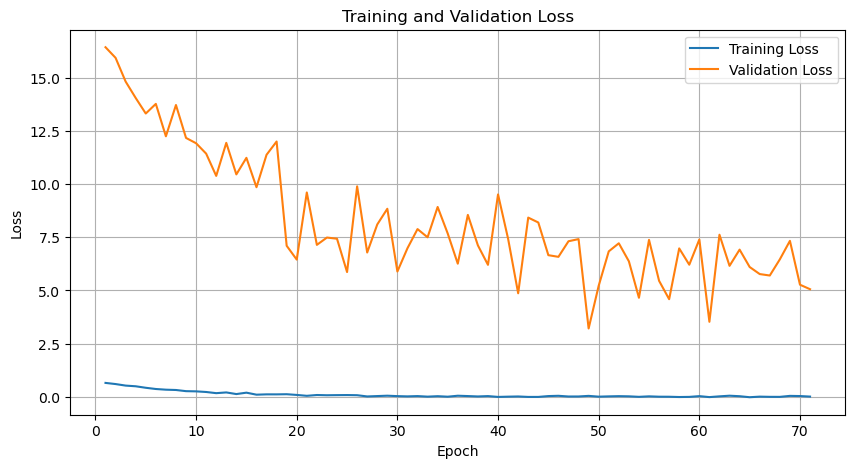

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Load training and validation losses from files
training_losses = np.load('training_losses.npy')
validation_losses = np.load('validation_losses.npy')
# Create an epoch axis (assuming one loss value per epoch)
epochs = np.arange(1, len(training_losses) + 1)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss', linestyle='-')
plt.plot(epochs, validation_losses, label='Validation Loss', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
